# AdventureGame Evaluation
This notebook produces tables and plots to analyse AdventureGame results. All plots and tables appearing in the AdventureGame paper are created using the contained code.

In [111]:
import sys
# sys.path.append('..')

from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import ListedColormap
from matplotlib.patches import Polygon

import evaluation.evalutils as utils
from evaluation.makingtables import build_dispersion_table
import clemgame.metrics as clemmetrics

Choose path for the .csv with the raw scores. This is created after running ```bencheval.py```.

In [112]:
RAW_PATH = Path('results/raw.csv')
raw_df = pd.read_csv(RAW_PATH, index_col=0)

Full results dataframe:

In [113]:
raw_df

,game,model,experiment,episode,metric,value
0,adventuregame,gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF...,0_home_deliver_three_basic_easy,episode_0,Violated Request Count,0.0
1,adventuregame,gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF...,0_home_deliver_three_basic_easy,episode_0,Parsed Request Count,50.0
2,adventuregame,gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF...,0_home_deliver_three_basic_easy,episode_0,Request Count,50.0
3,adventuregame,gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF...,0_home_deliver_three_basic_easy,episode_0,Request Success Ratio,1.0
4,adventuregame,gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF...,0_home_deliver_three_basic_easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
36731,adventuregame,Qwen2-72B-Instruct-t0.0--Qwen2-72B-Instruct-t0.0,3_home_deliver_three_planning_hard,episode_5,Played,0.0
36732,adventuregame,Qwen2-72B-Instruct-t0.0--Qwen2-72B-Instruct-t0.0,3_home_deliver_three_planning_hard,episode_6,Played,0.0
36733,adventuregame,Qwen2-72B-Instruct-t0.0--Qwen2-72B-Instruct-t0.0,3_home_deliver_three_planning_hard,episode_7,Played,1.0
36734,adventuregame,Qwen2-72B-Instruct-t0.0--Qwen2-72B-Instruct-t0.0,3_home_deliver_three_planning_hard,episode_8,Played,0.0


Dictionaries for converting full model, experiment and score/metric names to compact names:

In [114]:
model_name_dict = {
    'gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF-q5-t0.0': "gemma-2-9b-it-q5",
    'gemma-7b-it-Groq-t0.0--gemma-7b-it-Groq-t0.0': "gemma-7b-it",
    'gemma2-9b-it-Groq-t0.0--gemma2-9b-it-Groq-t0.0': "gemma2-9b-it",
    'Llama-3-70B-Instruct-Groq-t0.0--Llama-3-70B-Instruct-Groq-t0.0': "Llama-3-70B-Instruct",
    'Llama-3-8B-Instruct-Groq-t0.0--Llama-3-8B-Instruct-Groq-t0.0': "Llama-3-8B-Instruct",
    'llama-3.1-70b-versatile-Groq-t0.0--llama-3.1-70b-versatile-Groq-t0.0': "Llama-3.1-70b-Instruct",
    'llama-3.1-8b-instant-Groq-t0.0--llama-3.1-8b-instant-Groq-t0.0': "Llama-3.1-8b-Instruct",
    'LLaMA2-13B-Tiefighter-t0.0--LLaMA2-13B-Tiefighter-t0.0': "LLaMA2-13B-Tiefighter",
    'Meta-Llama-3.1-405B-Instruct-Turbo-TogetherAI-t0.0--Meta-Llama-3.1-405B-Instruct-Turbo-TogetherAI-t0.0': "Llama-3.1-405B-Instruct",
    'Mistral-Large-Instruct-2407-t0.0--Mistral-Large-Instruct-2407-t0.0': "Mistral-Large-Instruct-2407",
    'openchat_3.5-GGUF-q5-t0.0--openchat_3.5-GGUF-q5-t0.0': "openchat3.5-GGUF-q5",
    'openchat_3.5-t0.0--openchat_3.5-t0.0': "openchat3.5",
    'Qwen1.5-72B-Chat-t0.0--Qwen1.5-72B-Chat-t0.0': "Qwen1.5-72B-Chat",
    'Qwen2-72B-Instruct-t0.0--Qwen2-72B-Instruct-t0.0': "Qwen2-72B-Instruct"
}

experiment_short_name_dict = {
    '0_home_deliver_three_basic_easy': "basic-easy",
    '1_home_deliver_three_planning_easy': "planning-easy",
    '2_home_deliver_three_basic_hard': "basic-hard",
    '3_home_deliver_three_planning_hard': "planning-hard"
}

metric_name_dict = {
    'taking_from_inventory': "taking from inventory",
    'other_room_argument': "interacting with other room",
    'not_room_type': "going to non-existent room",
    'going_to_current_room': "going to current room",
    'no_exit_to': "going to non-adjacent room",
    'multiple_exits_to': "ambiguous traversal",
    'entity_already_inventory': "entity already in inventory",
    'thing_arg1_room': "first entity is room",
    'entity_not_accessible': "entity not accessible",
    'multiple_entity_ambiguity': "ambiguous entity",
    'thing_arg2_room': "second entity is room",
    'pre_state_mismatch': "main condition not fact",
    'action_parsing_fail': "parsing failure",
    'action_resolution_fail': "resolution failure",
    'lark_exception': "out of grammar",
    'malformed_command': "malformed command",
    'undefined_action_verb': "undefined action verb",
    'undefined_action': "undefined action type",
    'undefined_repr_str': "undefined noun",
    'manipulating_room': "manipulating room",
    'undefined_argument_type': "undefined antecedent",
    'successful_actions': "successful actions",
    'finish_speed': "finish speed"
}

Dataframe containing only AdventureGame results (needed in case AdventureGame was run along with other clemgames), with short model and experiment names:

In [115]:
game_df = raw_df[raw_df.game == 'adventuregame']
game_df = game_df.replace(model_name_dict).replace(experiment_short_name_dict)
game_df

,game,model,experiment,episode,metric,value
0,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,Violated Request Count,0.0
1,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,Parsed Request Count,50.0
2,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,Request Count,50.0
3,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,Request Success Ratio,1.0
4,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
36731,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_5,Played,0.0
36732,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_6,Played,0.0
36733,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_7,Played,1.0
36734,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_8,Played,0.0


## Overall benchmark scores

In [116]:
# read the clem scores
RESULTS_PATH = Path('results/results.csv')
clem_df = pd.read_csv(RESULTS_PATH, index_col=0)

Full overall score dataframe (useful in case other clemgames were run along with AdventureGame):

In [117]:
clem_df = clem_df.rename(model_name_dict)
clem_df

,"-, clemscore","adventuregame, % Played","adventuregame, Quality Score","adventuregame, Quality Score (std)","all, Average % Played","all, Average Quality Score"
LLaMA2-13B-Tiefighter,0.00,0.00,0.00,0.00,0.00,0.00
Llama-3-70B-Instruct,17.22,35.94,47.92,44.00,35.94,47.92
Llama-3-8B-Instruct,7.29,43.75,16.67,31.43,43.75,16.67
Llama-3.1-405B-Instruct,45.90,62.50,73.44,38.11,62.50,73.44
Mistral-Large-Instruct-2407,15.04,32.81,45.83,44.25,32.81,45.83
Qwen1.5-72B-Chat,2.69,17.19,15.62,26.54,17.19,15.62
Qwen2-72B-Instruct,32.47,65.62,49.48,44.44,65.62,49.48
gemma-2-9b-it-q5,12.64,57.81,21.87,33.18,57.81,21.87
gemma-7b-it,0.34,21.88,1.56,9.26,21.88,1.56
gemma2-9b-it,13.22,43.75,30.21,38.36,43.75,30.21


Overview dataframe, omitting averages for 'all games' (assumes only AdventureGame results present):

In [118]:
overview_df = clem_df.rename(model_name_dict).drop(columns=["all, Average % Played", "all, Average Quality Score"]).sort_values(by='-, clemscore', ascending=False)
overview_short_columns = {"-, clemscore": "clemscore", "adventuregame, % Played": "% Played", "adventuregame, Quality Score": "Quality Score", "adventuregame, Quality Score (std)": "Quality Score (std)"}
overview_df = overview_df.rename(columns=overview_short_columns)
overview_df

,clemscore,% Played,Quality Score,Quality Score (std)
Llama-3.1-405B-Instruct,45.90,62.50,73.44,38.11
Qwen2-72B-Instruct,32.47,65.62,49.48,44.44
Llama-3.1-70b-Instruct,25.64,46.88,54.69,43.39
Llama-3.1-8b-Instruct,23.13,76.56,30.21,35.99
Llama-3-70B-Instruct,17.22,35.94,47.92,44.00
Mistral-Large-Instruct-2407,15.04,32.81,45.83,44.25
openchat3.5,13.97,81.25,17.19,29.69
gemma2-9b-it,13.22,43.75,30.21,38.36
gemma-2-9b-it-q5,12.64,57.81,21.87,33.18
openchat3.5-GGUF-q5,7.35,67.19,10.94,23.04


In [119]:
overview_df.to_html("results/adventuregame_overview_table.html")
overview_df.to_csv("results/adventuregame_overview_table.csv")

In [120]:
overview_styled = overview_df.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(subset="clemscore", precision=2).format(subset="% Played", precision=2).format(subset="Quality Score", precision=2).format(subset="Quality Score (std)", precision=2)
overview_styled.to_latex('results/adventuregame_overview_table.tex')

Model comparison stacked bar plot:

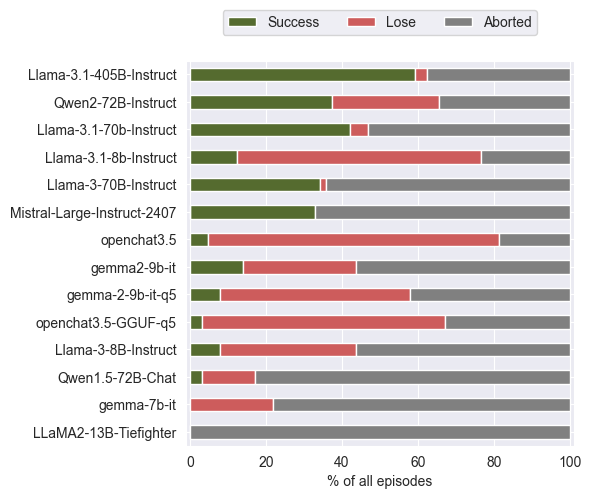

In [121]:
STACK_COLORS = ['darkolivegreen', 'indianred', 'gray']

df_aux = raw_df[raw_df.metric.isin(utils.GAMEPLAY_METRICS)]
df_aux = df_aux.replace(model_name_dict)

df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df.sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=3)
plt.xlabel('% of all episodes')
plt.xlim(-1, 101)
plt.ylabel('')
plt.show()

Bar plot with sorted clemscores:

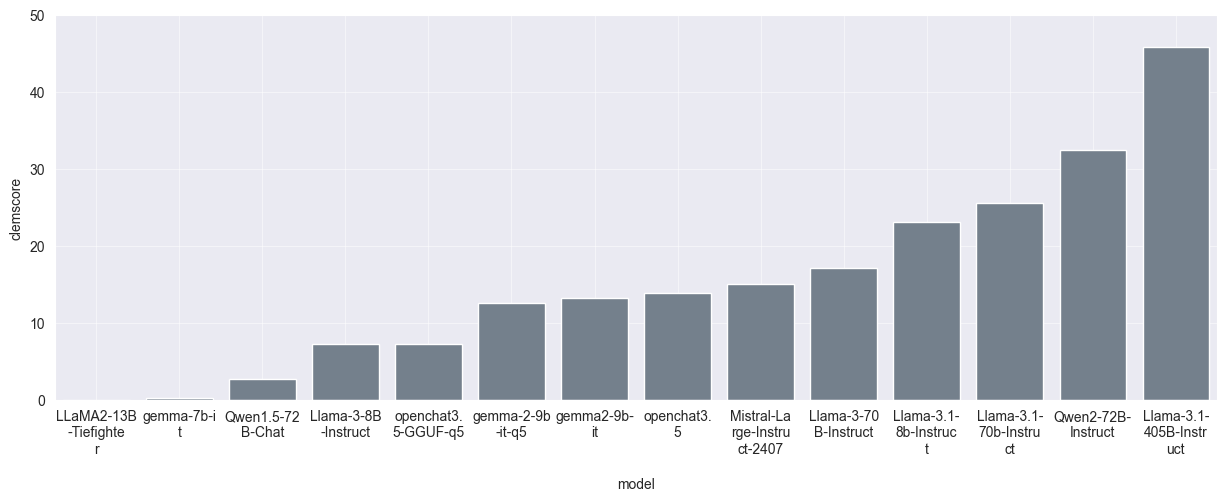

In [122]:
clem_aux = clem_df.sort_values(by='-, clemscore').reset_index(names='model').replace(model_name_dict)
# warning, if models have matching names up the limit, results will be wrongly merged!
clem_aux['model'] = clem_aux['model'].apply(lambda x: f'{x[:10]}\n{x[10:20]}\n{x[20:30]}\n{x[30:]}')

fig = plt.figure(figsize=(15, 5))
sns.barplot(clem_aux, x='model', y='-, clemscore', color='slategray')
# plt.ylim(-5, 105)
plt.ylim(0, 50)
plt.ylabel('clemscore')
plt.grid(alpha=0.5)
plt.show()

Omit models for which all episodes were aborted due to not following prompted format for detail analysis:

In [123]:
all_abort_models = ["LLaMA2-13B-Tiefighter"]
game_df = game_df.query('model not in ["LLaMA2-13B-Tiefighter"]')
game_df

,game,model,experiment,episode,metric,value
0,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,Violated Request Count,0.0
1,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,Parsed Request Count,50.0
2,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,Request Count,50.0
3,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,Request Success Ratio,1.0
4,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
36731,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_5,Played,0.0
36732,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_6,Played,0.0
36733,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_7,Played,1.0
36734,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_8,Played,0.0


## Failure metrics
### Failures by IF interpreter phase

In [124]:
failures_by_phase_df = game_df.query('metric in ["action_parsing_fail", "action_resolution_fail"]')
failures_by_phase_df

,game,model,experiment,episode,metric,value
5,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,action_parsing_fail,0.0
6,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,action_resolution_fail,16.0
45,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_1,action_parsing_fail,0.0
46,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_1,action_resolution_fail,18.0
85,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_10,action_parsing_fail,0.0
...,...,...,...,...,...,...
35726,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_7,action_resolution_fail,2.0
35765,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_8,action_parsing_fail,7.0
35766,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_8,action_resolution_fail,0.0
35805,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_9,action_parsing_fail,4.0


Bar plot showing failures by phase for all models over all experiments:

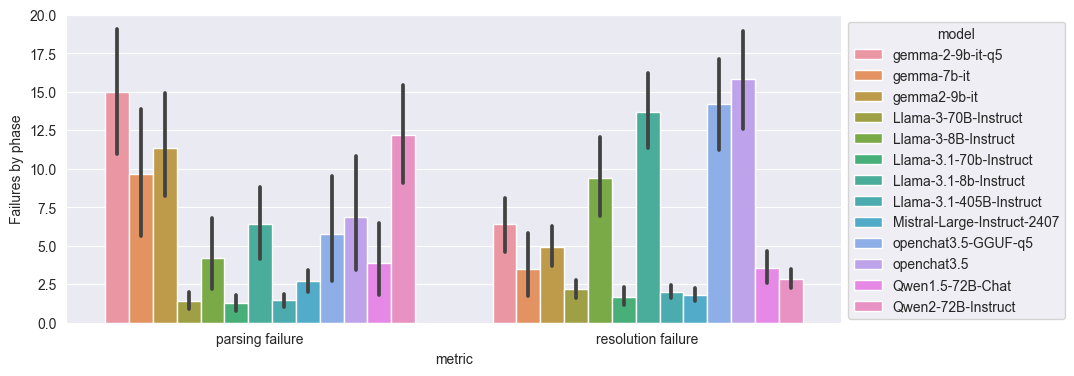

In [125]:
fig, ax = plt.subplots(figsize=(10, 4))

g = sns.barplot(failures_by_phase_df.replace(metric_name_dict),
                x='metric',
                y='value',
                hue='model',
                ax=ax)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.ylim(0, 20)
plt.ylabel("Failures by phase")

plt.show()

Dataframe with parsed request counts, ie actions passed to the IF interpreter (used to calculate failure ratios):

In [126]:
parsed_df = game_df[game_df.metric == "Parsed Request Count"].groupby(["model"]).sum()
parsed_df = parsed_df.drop(columns=["game", 'experiment', 'episode', 'metric'])
parsed_df

,value
model,
Llama-3-70B-Instruct,1167.0
Llama-3-8B-Instruct,1635.0
Llama-3.1-405B-Instruct,1342.0
Llama-3.1-70b-Instruct,1236.0
Llama-3.1-8b-Instruct,2407.0
Mistral-Large-Instruct-2407,1087.0
Qwen1.5-72B-Chat,1155.0
Qwen2-72B-Instruct,1981.0
gemma-2-9b-it-q5,2401.0


Counts of failures by phase for all models over all experiments:

In [127]:
failures_by_phase_counts = failures_by_phase_df.replace(metric_name_dict).groupby(['model', 'metric']).sum()
failures_by_phase_counts = failures_by_phase_counts.drop(columns=["game", 'experiment', 'episode'])
failures_by_phase_counts

value
model                       metric                    
Llama-3-70B-Instruct        parsing failure       92.0
                            resolution failure   139.0
Llama-3-8B-Instruct         parsing failure      270.0
                            resolution failure   602.0
Llama-3.1-405B-Instruct     parsing failure       93.0
                            resolution failure   129.0
Llama-3.1-70b-Instruct      parsing failure       81.0
                            resolution failure   106.0
Llama-3.1-8b-Instruct       parsing failure      412.0
                            resolution failure   874.0
Mistral-Large-Instruct-2407 parsing failure      172.0
                            resolution failure   117.0
Qwen1.5-72B-Chat            parsing failure      247.0
                            resolution failure   226.0
Qwen2-72B-Instruct          parsing failure      779.0
                            resolution failure   183.0
gemma-2-9b-it-q5            parsing failure      960.0
                            resolution failure   410.0
gemma-7b-it                 parsing failure      619.0
                            resolution failure   225.0
gemma2-9b-it                parsing failure      726.0
                            resolution failure   316.0
openchat3.5                 parsing failure      441.0
                            resolution failure  1012.0
openchat3.5-GGUF-q5         parsing failure      370.0
                            resolution failure   911.0

Ratios of failures by phase for all models over all experiments (calculated by dividing failures counts by parsed request counts):

In [128]:
failures_by_phase_ratios = failures_by_phase_counts / parsed_df
failures_by_phase_ratios

value
model                       metric                      
Llama-3-70B-Instruct        parsing failure     0.078835
                            resolution failure  0.119109
Llama-3-8B-Instruct         parsing failure     0.165138
                            resolution failure  0.368196
Llama-3.1-405B-Instruct     parsing failure     0.069300
                            resolution failure  0.096125
Llama-3.1-70b-Instruct      parsing failure     0.065534
                            resolution failure  0.085761
Llama-3.1-8b-Instruct       parsing failure     0.171167
                            resolution failure  0.363108
Mistral-Large-Instruct-2407 parsing failure     0.158234
                            resolution failure  0.107636
Qwen1.5-72B-Chat            parsing failure     0.213853
                            resolution failure  0.195671
Qwen2-72B-Instruct          parsing failure     0.393236
                            resolution failure  0.092378
gemma-2-9b-it-q5            parsing failure     0.399833
                            resolution failure  0.170762
gemma-7b-it                 parsing failure     0.642783
                            resolution failure  0.233645
gemma2-9b-it                parsing failure     0.359762
                            resolution failure  0.156591
openchat3.5                 parsing failure     0.169615
                            resolution failure  0.389231
openchat3.5-GGUF-q5         parsing failure     0.163283
                            resolution failure  0.402030

Overview/model comparison stacked bar plot for successful actions and failures by phase:

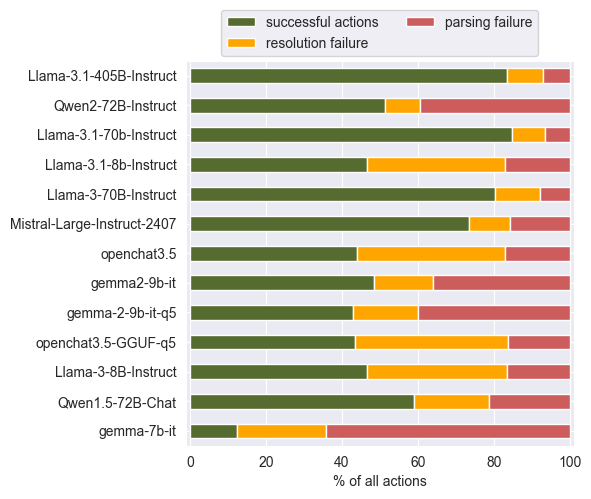

In [129]:
STACK_COLORS = ['darkolivegreen', 'orange', 'indianred']

phase_failures = ["action_parsing_fail", "action_resolution_fail", "successful_actions"]

df_aux = game_df[game_df.metric.isin(phase_failures)]
df_aux = df_aux.replace(metric_name_dict)

df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df.query('index not in ["LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=2)
plt.xlabel('% of all actions')
plt.xlim(-1, 101)
plt.ylabel('')
plt.show()

### Parsing failures
Dataframe with parsing failure counts/ratios:
Note: While "undefined_action" and "undefined_argument_type" did not occur in the v1 results, they are implemented, and thus not omitted here.

In [130]:
parsing_failures_df = game_df.query('metric in ["lark_exception", "malformed_command", "undefined_action", "undefined_action_verb", "undefined_repr_str", "undefined_argument_type"]')
parsing_failures_df = parsing_failures_df.replace(metric_name_dict)
parsing_failures_counts = parsing_failures_df.groupby(['model', 'metric']).sum()
parsing_failures_counts = parsing_failures_counts.drop(columns=["game", 'experiment', 'episode'])
parsing_failures_counts['Ratio'] = parsing_failures_counts / parsed_df
parsing_failures_counts = parsing_failures_counts.rename(columns={"value": "Count"})
parsing_failures_counts

Count     Ratio
model                metric                                
Llama-3-70B-Instruct malformed command        0.0  0.000000
                     out of grammar           9.0  0.007712
                     undefined action type    0.0  0.000000
                     undefined action verb   69.0  0.059126
                     undefined antecedent     0.0  0.000000
...                                           ...       ...
openchat3.5-GGUF-q5  out of grammar          57.0  0.025154
                     undefined action type    0.0  0.000000
                     undefined action verb  216.0  0.095322
                     undefined antecedent     0.0  0.000000
                     undefined noun          46.0  0.020300

[78 rows x 2 columns]

In [131]:
parsing_failures_counts.style.format(subset="Count", precision=0).format(subset="Ratio", precision=3).to_latex('results/parsing_failures_table.tex', clines="skip-last;data")

Overview/model comparison stacked bar plot for parsing failures:
Note: Non-occurring parsing failure types are omitted here.

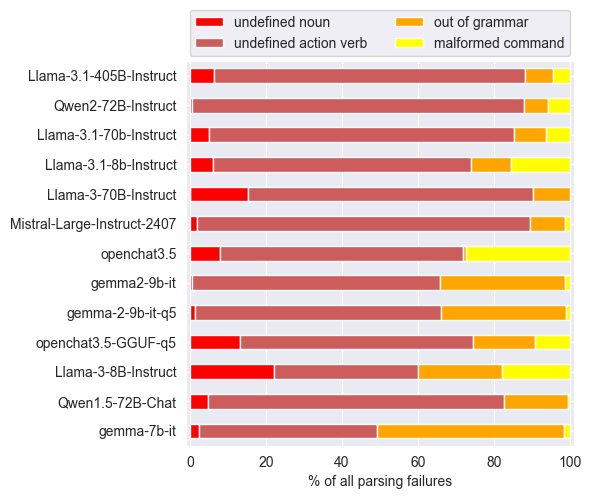

In [132]:
STACK_COLORS = ['red', 'indianred', 'orange', 'yellow']

parse_failures = ["lark_exception", "malformed_command", "undefined_action_verb", "undefined_repr_str"]

df_aux = game_df[game_df.metric.isin(parse_failures)]
df_aux = df_aux.replace(metric_name_dict)

df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df.query('index not in ["LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=2)
plt.xlabel('% of all parsing failures')
plt.xlim(-1, 101)
plt.ylabel('')
plt.show()

### Room/navigation failures
Dataframe with room/navigation failure counts/ratios:
Note: While "thing_arg1_room" and "thing_arg2_room" did not occur in the v1 results, they are implemented, and thus not omitted here.

In [133]:
room_failures_df = game_df.query('metric in ["not_room_type", "no_exit_to", "manipulating_room", "other_room_argument", "thing_arg1_room", "thing_arg2_room"]')
room_failures_df = room_failures_df.replace(metric_name_dict)
room_failures_counts = room_failures_df.groupby(['model', 'metric']).sum()
room_failures_counts = room_failures_counts.drop(columns=["game", 'experiment', 'episode'])
room_failures_counts['ratio'] = room_failures_counts / parsed_df
room_failures_counts

value     ratio
model                metric                                      
Llama-3-70B-Instruct first entity is room           0.0  0.000000
                     going to non-adjacent room    64.0  0.054841
                     going to non-existent room     4.0  0.003428
                     interacting with other room    0.0  0.000000
                     manipulating room              0.0  0.000000
...                                                 ...       ...
openchat3.5-GGUF-q5  going to non-adjacent room   282.0  0.124448
                     going to non-existent room     9.0  0.003972
                     interacting with other room   15.0  0.006620
                     manipulating room              0.0  0.000000
                     second entity is room          0.0  0.000000

[78 rows x 2 columns]

Overview/model comparison stacked bar plot for room/navigation failures:
Note: Non-occurring room/navigation failure types are omitted here.

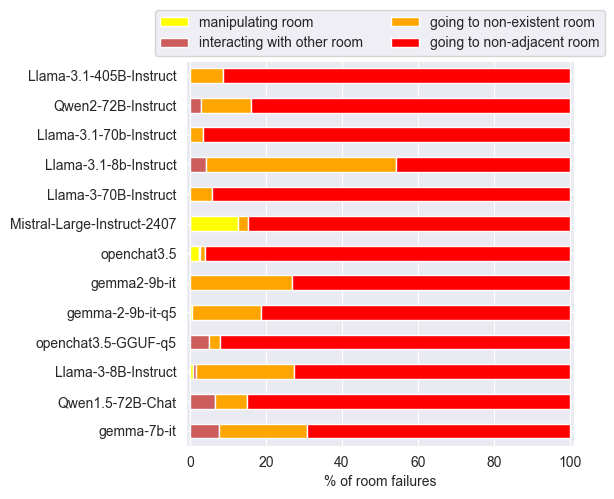

In [134]:
STACK_COLORS = ['yellow', 'orange', 'indianred', 'yellow', 'orange', 'red']

room_failures = ["not_room_type", "no_exit_to", "manipulating_room", "other_room_argument"]

df_aux = game_df[game_df.metric.isin(room_failures)]
df_aux = df_aux.replace(metric_name_dict)

df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df.query('index not in ["LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=2)
plt.xlabel('% of room failures')
plt.xlim(-1, 101)
plt.ylabel('')
plt.show()

### Entity-related failures
Dataframe with entity-related failure counts/ratios:

In [135]:
entity_failures_df = game_df.query('metric in ["entity_not_accessible", "entity_already_inventory", "pre_state_mismatch"]')
entity_failures_df = entity_failures_df.replace(metric_name_dict)
entity_failures_counts = entity_failures_df.groupby(['model', 'metric']).sum()
entity_failures_counts = entity_failures_counts.drop(columns=["game", 'experiment', 'episode'])
entity_failures_counts['ratio'] = entity_failures_counts / parsed_df
entity_failures_counts

value     ratio
model                       metric                                      
Llama-3-70B-Instruct        entity already in inventory    0.0  0.000000
                            entity not accessible         69.0  0.059126
                            main condition not fact        2.0  0.001714
Llama-3-8B-Instruct         entity already in inventory    5.0  0.003058
                            entity not accessible        274.0  0.167584
                            main condition not fact      195.0  0.119266
Llama-3.1-405B-Instruct     entity already in inventory    0.0  0.000000
                            entity not accessible         48.0  0.035768
                            main condition not fact        0.0  0.000000
Llama-3.1-70b-Instruct      entity already in inventory    0.0  0.000000
                            entity not accessible         46.0  0.037217
                            main condition not fact        2.0  0.001618
Llama-3.1-8b-Instruct       entity already in inventory    6.0  0.002493
                            entity not accessible        430.0  0.178646
                            main condition not fact      171.0  0.071043
Mistral-Large-Instruct-2407 entity already in inventory    0.0  0.000000
                            entity not accessible         46.0  0.042318
                            main condition not fact        0.0  0.000000
Qwen1.5-72B-Chat            entity already in inventory    0.0  0.000000
                            entity not accessible         78.0  0.067532
                            main condition not fact        1.0  0.000866
Qwen2-72B-Instruct          entity already in inventory    1.0  0.000505
                            entity not accessible         51.0  0.025745
                            main condition not fact        1.0  0.000505
gemma-2-9b-it-q5            entity already in inventory    1.0  0.000416
                            entity not accessible        233.0  0.097043
                            main condition not fact       15.0  0.006247
gemma-7b-it                 entity already in inventory    0.0  0.000000
                            entity not accessible        212.0  0.220145
                            main condition not fact        1.0  0.001038
gemma2-9b-it                entity already in inventory    1.0  0.000496
                            entity not accessible        154.0  0.076313
                            main condition not fact       20.0  0.009911
openchat3.5                 entity already in inventory    3.0  0.001154
                            entity not accessible        611.0  0.235000
                            main condition not fact       24.0  0.009231
openchat3.5-GGUF-q5         entity already in inventory    5.0  0.002207
                            entity not accessible        553.0  0.244042
                            main condition not fact       26.0  0.011474

Overview/model comparison stacked bar plot for entity-related failures:

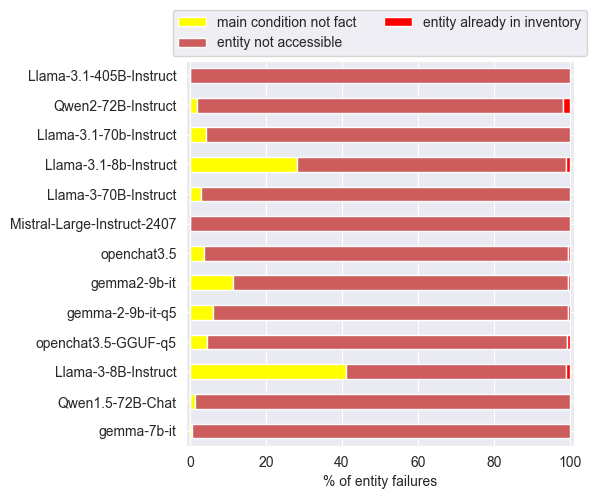

In [136]:
STACK_COLORS = ['yellow', 'indianred', 'red']

entity_failures = ["entity_not_accessible", "entity_already_inventory", "pre_state_mismatch"]

df_aux = game_df[game_df.metric.isin(entity_failures)]
df_aux = df_aux.replace(metric_name_dict)

df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df.query('index not in ["LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=2)
plt.xlabel('% of entity failures')
plt.xlim(-1, 101)
plt.ylabel('')
plt.show()

## Overview tables
Dispersion metrics over all episodes. Note that this uses groupby, which will ignore NaN values, according to the clembench documentation!

In [137]:
stats_df = build_dispersion_table(['game', 'model', 'metric'], game_df) # could also use raw_df for results for all games
stats_df

mean   
game          model                metric                               
adventuregame Llama-3-70B-Instruct Aborted                   0.640625  \
                                   Lose                      0.015625   
                                   Main Score               47.916667   
                                   Parsed Request Count     18.234375   
                                   Played                    0.359375   
...                                                               ...   
              openchat3.5-GGUF-q5  turns_over_par           10.000000   
                                   undefined_action          0.000000   
                                   undefined_action_verb     3.375000   
                                   undefined_argument_type   0.000000   
                                   undefined_repr_str        0.718750   

                                                                  std   
game          model                metric                               
adventuregame Llama-3-70B-Instruct Aborted                   0.483610  \
                                   Lose                      0.125000   
                                   Main Score               43.995751   
                                   Parsed Request Count     10.433070   
                                   Played                    0.483610   
...                                                               ...   
              openchat3.5-GGUF-q5  turns_over_par           11.313708   
                                   undefined_action          0.000000   
                                   undefined_action_verb    11.335434   
                                   undefined_argument_type   0.000000   
                                   undefined_repr_str        3.538759   

                                                                    var   
game          model                metric                                 
adventuregame Llama-3-70B-Instruct Aborted                     0.233879  \
                                   Lose                        0.015625   
                                   Main Score               1935.626102   
                                   Parsed Request Count      108.848958   
                                   Played                      0.233879   
...                                                                 ...   
              openchat3.5-GGUF-q5  turns_over_par            128.000000   
                                   undefined_action            0.000000   
                                   undefined_action_verb     128.492063   
                                   undefined_argument_type     0.000000   
                                   undefined_repr_str         12.522817   

                                                               median    max   
game          model                metric                                      
adventuregame Llama-3-70B-Instruct Aborted                   1.000000    1.0  \
                                   Lose                      0.000000    1.0   
                                   Main Score               33.333333  100.0   
                                   Parsed Request Count     16.500000   50.0   
                                   Played                    0.000000    1.0   
...                                                               ...    ...   
              openchat3.5-GGUF-q5  turns_over_par           10.000000   18.0   
                                   undefined_action          0.000000    0.0   
                                   undefined_action_verb     0.000000   48.0   
                                   undefined_argument_type   0.000000    0.0   
                                   undefined_repr_str        0.000000   25.0   

                                                            min      skew  
game          model                metric                               

In [138]:
failure_stats_by_phase_df = stats_df.query('metric in ["action_parsing_fail", "action_resolution_fail"]')
failure_stats_by_phase_df

mean   
game          model                       metric                              
adventuregame Llama-3-70B-Instruct        action_parsing_fail      1.437500  \
                                          action_resolution_fail   2.171875   
              Llama-3-8B-Instruct         action_parsing_fail      4.218750   
                                          action_resolution_fail   9.406250   
              Llama-3.1-405B-Instruct     action_parsing_fail      1.453125   
                                          action_resolution_fail   2.015625   
              Llama-3.1-70b-Instruct      action_parsing_fail      1.265625   
                                          action_resolution_fail   1.656250   
              Llama-3.1-8b-Instruct       action_parsing_fail      6.437500   
                                          action_resolution_fail  13.656250   
              Mistral-Large-Instruct-2407 action_parsing_fail      2.687500   
                                          action_resolution_fail   1.828125   
              Qwen1.5-72B-Chat            action_parsing_fail      3.859375   
                                          action_resolution_fail   3.531250   
              Qwen2-72B-Instruct          action_parsing_fail     12.171875   
                                          action_resolution_fail   2.859375   
              gemma-2-9b-it-q5            action_parsing_fail     15.000000   
                                          action_resolution_fail   6.406250   
              gemma-7b-it                 action_parsing_fail      9.671875   
                                          action_resolution_fail   3.515625   
              gemma2-9b-it                action_parsing_fail     11.343750   
                                          action_resolution_fail   4.937500   
              openchat3.5                 action_parsing_fail      6.890625   
                                          action_resolution_fail  15.812500   
              openchat3.5-GGUF-q5         action_parsing_fail      5.781250   
                                          action_resolution_fail  14.234375   

                                                                        std   
game          model                       metric                              
adventuregame Llama-3-70B-Instruct        action_parsing_fail      2.280873  \
                                          action_resolution_fail   2.285598   
              Llama-3-8B-Instruct         action_parsing_fail      9.585817   
                                          action_resolution_fail  11.043520   
              Llama-3.1-405B-Instruct     action_parsing_fail      1.699016   
                                          action_resolution_fail   1.821322   
              Llama-3.1-70b-Instruct      action_parsing_fail      2.139887   
                                          action_resolution_fail   2.358495   
              Llama-3.1-8b-Instruct       action_parsing_fail      9.894483   
                                          action_resolution_fail  10.220146   
              Mistral-Large-Instruct-2407 action_parsing_fail      2.937848   
                                          action_resolution_fail   1.821866   
              Qwen1.5-72B-Chat            action_parsing_fail      9.463157   
                                          action_resolution_fail   4.331387   
              Qwen2-72B-Instruct          action_parsing_fail     13.060974   
                                          action_resolution_fail   2.647953   
              gemma-2-9b-it-q5            action_parsing_fail     17.457431   
                                          action_resolution_fail   7.245620   
              gemma-7b-it                 action_parsing_fail     16.923783   
                                          action_resolution_fail   8.596773   
              gemma2-9b-it                action_parsing_fail     13.239214   
                                         

Break results down by experiment:

In [139]:
detailed_stats_df = build_dispersion_table(['game', 'model', 'experiment', 'metric'], game_df) # could also use raw_df for results for all games
detailed_stats_df

mean   
game          model                experiment    metric                             
adventuregame Llama-3-70B-Instruct basic-easy    Aborted                   0.4375  \
                                                 Lose                      0.0000   
                                                 Main Score               56.2500   
                                                 Parsed Request Count     17.3125   
                                                 Played                    0.5625   
...                                                                           ...   
              openchat3.5-GGUF-q5  planning-hard turns_over_par               NaN   
                                                 undefined_action          0.0000   
                                                 undefined_action_verb     0.9375   
                                                 undefined_argument_type   0.0000   
                                                 undefined_repr_str        2.6875   

                                                                                std   
game          model                experiment    metric                               
adventuregame Llama-3-70B-Instruct basic-easy    Aborted                   0.512348  \
                                                 Lose                      0.000000   
                                                 Main Score               51.234754   
                                                 Parsed Request Count      7.162111   
                                                 Played                    0.512348   
...                                                                             ...   
              openchat3.5-GGUF-q5  planning-hard turns_over_par                 NaN   
                                                 undefined_action          0.000000   
                                                 undefined_action_verb     2.462214   
                                                 undefined_argument_type   0.000000   
                                                 undefined_repr_str        6.848053   

                                                                                  var   
game          model                experiment    metric                                 
adventuregame Llama-3-70B-Instruct basic-easy    Aborted                     0.262500  \
                                                 Lose                        0.000000   
                                                 Main Score               2625.000000   
                                                 Parsed Request Count       51.295833   
                                                 Played                      0.262500   
...                                                                               ...   
              openchat3.5-GGUF-q5  planning-hard turns_over_par                   NaN   
                                                 undefined_action            0.000000   
                                                 undefined_action_verb       6.062500   
                                                 undefined_argument_type     0.000000   
                                                 undefined_repr_str         46.895833   

                                                                          median   
game          model                experiment    metric                            
adventuregame Llama-3-70B-Instruct basic-easy    Aborted                     0.0  \
                                                 Lose                        0.0   
                                                 Main Score                100.0   
                                                 Parsed Request Count       14.5   
                                                 Played                      1.0   
...                                                                          ...   
         

In [140]:
stats_df.to_csv('results/adventuregame_stats.csv')
detailed_stats_df.to_csv('results/adventuregame_stats_detailed.csv')

In [141]:
stats_df.to_html('results/adventuregame_stats.html')
detailed_stats_df.to_html('results/adventuregame_stats_detailed.html')

Condensed tables:

In [142]:
game_df

,game,model,experiment,episode,metric,value
0,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,Violated Request Count,0.0
1,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,Parsed Request Count,50.0
2,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,Request Count,50.0
3,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,Request Success Ratio,1.0
4,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
36731,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_5,Played,0.0
36732,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_6,Played,0.0
36733,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_7,Played,1.0
36734,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_8,Played,0.0


In [143]:
selected_stats_df = game_df.drop(columns=["game"])
selected_metrics_list = ["Main Score", "Played", "Success", "action_parsing_fail", "action_resolution_fail", "successful_actions", "finish_speed"]
selected_stats_df = selected_stats_df.query('metric in ["Main Score", "Played", "finish_speed"]')
selected_stats_df = build_dispersion_table(['model', 'experiment', 'metric'], selected_stats_df)
selected_stats_df = selected_stats_df.drop(columns=["var", "median", "max", "min", "skew"])
selected_stats_df = selected_stats_df.rename(metric_name_dict)
selected_stats_df = selected_stats_df.rename({"finish speed": "Speed", "Main Score": "Score"})
selected_stats_df = selected_stats_df.reset_index()
selected_stats_df = pd.pivot_table(selected_stats_df, index=['model', 'experiment'], columns='metric')
selected_stats_df

mean                        
metric                                     Played      Score     Speed   
model                       experiment                                   
Llama-3-70B-Instruct        basic-easy     0.5625  56.250000  0.140522  \
                            basic-hard     0.2500  52.083333  0.432005   
                            planning-easy  0.5625  60.416667  0.110419   
                            planning-hard  0.0625  22.916667  0.200000   
Llama-3-8B-Instruct         basic-easy     0.8125  27.083333  0.289947   
                            basic-hard     0.8125  31.250000  0.588235   
                            planning-easy  0.0625   8.333333  0.450000   
                            planning-hard  0.0625   0.000000       NaN   
Llama-3.1-405B-Instruct     basic-easy     0.7500  75.000000  0.072432   
                            basic-hard     0.8125  89.583333  0.418995   
                            planning-easy  0.5625  64.583333  0.091563   
                            planning-hard  0.3750  64.583333  0.230226   
Llama-3.1-70b-Instruct      basic-easy     0.7500  68.750000  0.076791   
                            basic-hard     0.3125  50.000000  0.404698   
                            planning-easy  0.6250  62.500000  0.084445   
                            planning-hard  0.1875  37.500000  0.135057   
Llama-3.1-8b-Instruct       basic-easy     1.0000  41.666667  0.255251   
                            basic-hard     1.0000  29.166667       NaN   
                            planning-easy  0.6250  31.250000  0.186111   
                            planning-hard  0.4375  18.750000  0.366667   
Mistral-Large-Instruct-2407 basic-easy     0.5000  64.583333  0.119561   
                            basic-hard     0.3125  47.916667  0.311908   
                            planning-easy  0.3750  45.833333  0.129808   
                            planning-hard  0.1250  25.000000  0.452087   
Qwen1.5-72B-Chat            basic-easy     0.1875  33.333333  0.023810   
                            basic-hard     0.3750  18.750000       NaN   
                            planning-easy  0.0625   8.333333  0.023810   
                            planning-hard  0.0625   2.083333       NaN   
Qwen2-72B-Instruct          basic-easy     0.9375  81.250000  0.196348   
                            basic-hard     1.0000  47.916667  0.450756   
                            planning-easy  0.3125  39.583333  0.207714   
                            planning-hard  0.3750  29.166667  0.511521   
gemma-2-9b-it-q5            basic-easy     0.6250  35.416667  0.166667   
                            basic-hard     0.6250  33.333333  0.931034   
                            planning-easy  0.4375  14.583333  0.051282   
                            planning-hard  0.6250   4.166667       NaN   
gemma-7b-it                 basic-easy     0.3750   6.250000       NaN   
                            basic-hard     0.3750   0.000000       NaN   
                            planning-easy  0.1250   0.000000       NaN   
                            planning-hard  0.0000   0.000000       NaN   
gemma2-9b-it                basic-easy     0.4375  37.500000  0.054555   
                            basic-hard     0.7500  33.333333  0.173810   
                            planning-easy  0.3750  29.166667  0.063591   
                            planning-hard  0.1875  20.833333       NaN   
openchat3.5                 basic-easy     1.0000  39.583333  0.331349   
                            basic-hard     1.0000  12.500000       NaN   
                            planning-easy  0.6875  10.416667       NaN   
                            planning-hard  0.5625   6.250000       NaN   
openchat3.5-GGUF-q5         basic-easy     0.8750  18.750000  0.450000   
                            basic-hard     0.8750  14.583333       NaN   
                            planning-easy  0.4375   8.333333  0.047619   
                            planning-hard  0.5000

In [144]:
selected_stats_df.to_html("results/selected_stats.html")

In [145]:
selected_stats_styled = selected_stats_df.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(precision=2)
selected_stats_styled.to_latex("results/selected_stats.tex", clines="skip-last;data")

Planning variant:

In [146]:
plan_df = game_df.query('experiment in ["planning-easy", "planning-hard"]')
plan_df

,game,model,experiment,episode,metric,value
640,adventuregame,gemma-2-9b-it-q5,planning-easy,episode_0,Violated Request Count,1.000
641,adventuregame,gemma-2-9b-it-q5,planning-easy,episode_0,Parsed Request Count,7.000
642,adventuregame,gemma-2-9b-it-q5,planning-easy,episode_0,Request Count,8.000
643,adventuregame,gemma-2-9b-it-q5,planning-easy,episode_0,Request Success Ratio,0.875
644,adventuregame,gemma-2-9b-it-q5,planning-easy,episode_0,hallucination_count,0.000
...,...,...,...,...,...,...
36731,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_5,Played,0.000
36732,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_6,Played,0.000
36733,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_7,Played,1.000
36734,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_8,Played,0.000


In [147]:
selected_plan_df = plan_df.drop(columns=["game"])
selected_plan_df = selected_plan_df.query('metric in ["plan_average_viability_ratio", "plan_followed_ratio", "bad_plan_dismiss_ratio"]')

selected_plan_df = build_dispersion_table(['model', 'experiment', 'metric'], selected_plan_df)
selected_plan_df = selected_plan_df.drop(columns=["var", "median", "max", "min", "skew"])

selected_plan_df = selected_plan_df.rename(metric_name_dict)
selected_plan_df = selected_plan_df.rename({"plan_average_viability_ratio": "Viable", "plan_followed_ratio": "Follow", "bad_plan_dismiss_ratio": "Adapt"})

selected_plan_df = selected_plan_df.reset_index()
selected_plan_df = pd.pivot_table(selected_plan_df, index=['model', 'experiment'], columns='metric')

selected_plan_df

mean                       
metric                                        Adapt    Follow    Viable   
model                       experiment                                    
Llama-3-70B-Instruct        planning-easy  0.935119  0.550135  0.310709  \
                            planning-hard  0.916635  0.266777  0.117673   
Llama-3-8B-Instruct         planning-easy  0.908009  0.180885  0.149258   
                            planning-hard  0.882203  0.186822  0.057721   
Llama-3.1-405B-Instruct     planning-easy  0.996094  0.259569  0.179920   
                            planning-hard  0.979638  0.096422  0.054078   
Llama-3.1-70b-Instruct      planning-easy  0.947766  0.557229  0.348566   
                            planning-hard  0.903354  0.270256  0.096686   
Llama-3.1-8b-Instruct       planning-easy  0.893669  0.232618  0.196768   
                            planning-hard  0.912701  0.161273  0.066671   
Mistral-Large-Instruct-2407 planning-easy  0.947064  0.277438  0.178463   
                            planning-hard  0.959506  0.115250  0.084063   
Qwen1.5-72B-Chat            planning-easy  0.783036  0.389013  0.140156   
                            planning-hard  0.899555  0.237524  0.063994   
Qwen2-72B-Instruct          planning-easy  0.956452  0.174135  0.069757   
                            planning-hard  0.986633  0.022905  0.003564   
gemma-2-9b-it-q5            planning-easy  0.966771  0.167541  0.129658   
                            planning-hard  0.976876  0.043373  0.027092   
gemma-7b-it                 planning-easy  0.776548  0.232381  0.035714   
                            planning-hard  0.918025  0.102808  0.031250   
gemma2-9b-it                planning-easy  0.966841  0.139115  0.137062   
                            planning-hard  0.985005  0.051769  0.074311   
openchat3.5                 planning-easy  0.838062  0.248327  0.048735   
                            planning-hard  0.890372  0.171572  0.082211   
openchat3.5-GGUF-q5         planning-easy  0.871471  0.167059  0.039296   
                            planning-hard  0.924523  0.121133  0.033470   

                                                std                      
metric                                        Adapt    Follow    Viable  
model                       experiment                                   
Llama-3-70B-Instruct        planning-easy  0.052063  0.092178  0.096505  
                            planning-hard  0.100605  0.204341  0.133971  
Llama-3-8B-Instruct         planning-easy  0.114473  0.164814  0.101704  
                            planning-hard  0.153320  0.160814  0.071730  
Llama-3.1-405B-Instruct     planning-easy  0.015625  0.183167  0.101930  
                            planning-hard  0.030370  0.082750  0.030041  
Llama-3.1-70b-Instruct      planning-easy  0.043713  0.124466  0.111636  
                            planning-hard  0.077029  0.167870  0.073410  
Llama-3.1-8b-Instruct       planning-easy  0.075510  0.168906  0.155731  
                            planning-hard  0.121526  0.160236  0.062719  
Mistral-Large-Instruct-2407 planning-easy  0.073572  0.234496  0.130039  
                            planning-hard  0.052774  0.153330  0.059685  
Qwen1.5-72B-Chat            planning-easy  0.122730  0.175148  0.179156  
                            planning-hard  0.100265  0.158785  0.080033  
Qwen2-72B-Instruct          planning-easy  0.059582  0.233569  0.118714  
                            planning-hard  0.026445  0.045615  0.004531  
gemma-2-9b-it-q5            planning-easy  0.042528  0.184420  0.147817  
                            planning-hard  0.020976  0.041242  0.024465  
gemma-7b-it                 planning-easy  0.250921  0.261044  0.125085  
                            planning-hard  0.179319  0.188298  0.057935  
gemma2-9b-it                planning-easy  0.070524  0.207731  0.190678  
                            planning-hard  0.048752  0.116689  0.080685  
openchat3.5          

In [148]:
selected_plan_styled = selected_plan_df.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(precision=2)
selected_plan_styled.to_latex("results/selected_planning.tex", clines="skip-last;data")

Hallucinations:

In [149]:
hallucination_df = game_df[game_df.metric == 'hallucination_count']
hallucination_df

,game,model,experiment,episode,metric,value
4,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,hallucination_count,0.0
44,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_1,hallucination_count,0.0
84,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_10,hallucination_count,0.0
124,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_11,hallucination_count,0.0
164,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_12,hallucination_count,0.0
...,...,...,...,...,...,...
35644,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_5,hallucination_count,0.0
35684,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_6,hallucination_count,0.0
35724,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_7,hallucination_count,0.0
35764,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_8,hallucination_count,0.0


In [150]:
llama3_1_70b_hallu = hallucination_df.query('model == "Llama-3.1-70b-Instruct" and value == 1')
llama3_1_70b_hallu

,game,model,experiment,episode,metric,value
13004,adventuregame,Llama-3.1-70b-Instruct,basic-easy,episode_13,hallucination_count,1.0
13524,adventuregame,Llama-3.1-70b-Instruct,planning-easy,episode_10,hallucination_count,1.0
13564,adventuregame,Llama-3.1-70b-Instruct,planning-easy,episode_11,hallucination_count,1.0
13604,adventuregame,Llama-3.1-70b-Instruct,planning-easy,episode_12,hallucination_count,1.0
13644,adventuregame,Llama-3.1-70b-Instruct,planning-easy,episode_13,hallucination_count,1.0
13684,adventuregame,Llama-3.1-70b-Instruct,planning-easy,episode_14,hallucination_count,1.0
13724,adventuregame,Llama-3.1-70b-Instruct,planning-easy,episode_15,hallucination_count,1.0
14124,adventuregame,Llama-3.1-70b-Instruct,basic-hard,episode_1,hallucination_count,1.0
14164,adventuregame,Llama-3.1-70b-Instruct,basic-hard,episode_10,hallucination_count,1.0
14244,adventuregame,Llama-3.1-70b-Instruct,basic-hard,episode_12,hallucination_count,1.0


In [151]:
hallucination_counts = hallucination_df.groupby(['model']).sum()
hallucination_sums = hallucination_counts.iloc[0:14, [4]]
hallucination_sums['Ratio'] = hallucination_sums.value / 64
hallucination_sums = hallucination_sums.rename(columns = {"value": "Total"})
hallucination_sums

,Total,Ratio
model,,
Llama-3-70B-Instruct,19.0,0.296875
Llama-3-8B-Instruct,4.0,0.062500
Llama-3.1-405B-Instruct,9.0,0.140625
Llama-3.1-70b-Instruct,14.0,0.218750
Llama-3.1-8b-Instruct,0.0,0.000000
Mistral-Large-Instruct-2407,4.0,0.062500
Qwen1.5-72B-Chat,10.0,0.156250
Qwen2-72B-Instruct,3.0,0.046875
gemma-2-9b-it-q5,5.0,0.078125


In [152]:
hallucination_sums.to_html('results/hallucination_sums.html')

In [153]:
h_styled = hallucination_sums.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(subset="Ratio", precision=3).format(subset="Total", precision=0)
h_styled.to_latex('results/hallucination_sums.tex')

In [154]:
h_styled = hallucination_sums.style.format(subset="Ratio", precision=3).format(subset="Total", precision=0).to_latex('results/hallucination_sums.tex', clines="skip-last;data")

In [155]:
detailed_hallucination_df = build_dispersion_table(['model'], hallucination_df)
detailed_hallucination_df

,mean,std,var,median,max,min,skew
model,,,,,,,
Llama-3-70B-Instruct,0.296875,0.460493,0.212054,0.0,1.0,0.0,0.910665
Llama-3-8B-Instruct,0.062500,0.243975,0.059524,0.0,1.0,0.0,3.702124
Llama-3.1-405B-Instruct,0.140625,0.350382,0.122768,0.0,1.0,0.0,2.117502
Llama-3.1-70b-Instruct,0.218750,0.416667,0.173611,0.0,1.0,0.0,1.393548
Llama-3.1-8b-Instruct,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
Mistral-Large-Instruct-2407,0.062500,0.243975,0.059524,0.0,1.0,0.0,3.702124
Qwen1.5-72B-Chat,0.156250,0.365963,0.133929,0.0,1.0,0.0,1.939208
Qwen2-72B-Instruct,0.046875,0.213042,0.045387,0.0,1.0,0.0,4.391077
gemma-2-9b-it-q5,0.078125,0.270490,0.073165,0.0,1.0,0.0,3.219966


## Specific metrics plots
Bar plot overview by model and experiment:

In [156]:
def metric_bar_plot(source_df, metric, max_value=1):
    metric_df = source_df[game_df.metric == metric].sort_values('experiment')
    fig, ax = plt.subplots(figsize=(10, 4))

    g = sns.barplot(metric_df,
                x='experiment',
                y='value',
                hue='model', 
                ax=ax)

    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    plt.ylim(0, max_value)
    plt.ylabel(metric)

    plt.show()

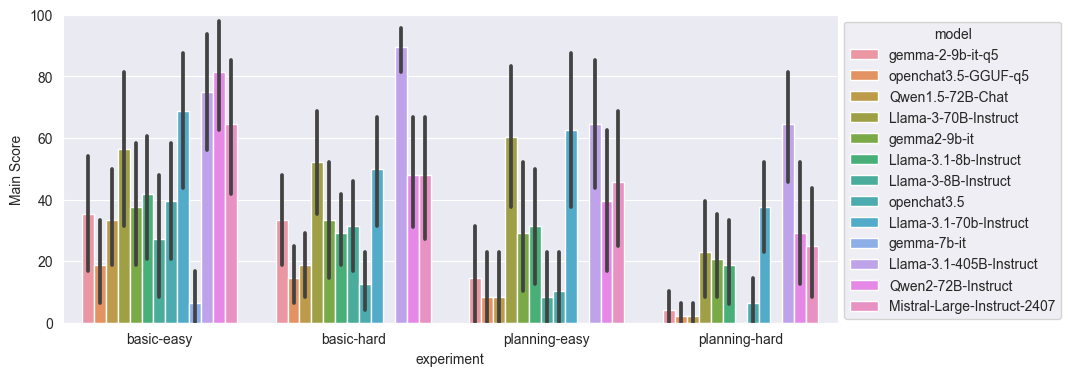

In [157]:
metric_bar_plot(game_df, "Main Score", max_value=100)

Only considering finished instances:

D:\clembench\venv_llamacpp\Lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
D:\clembench\venv_llamacpp\Lib\site-packages\numpy\lib\nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


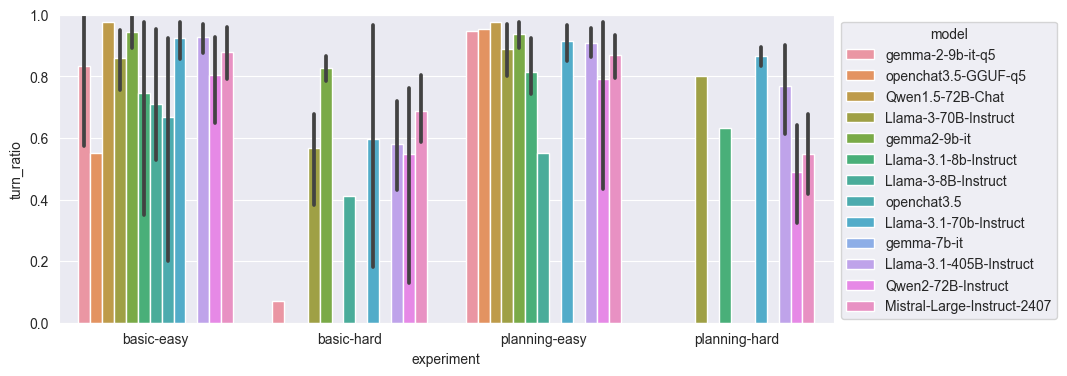

In [158]:
metric_bar_plot(game_df, "turn_ratio")

D:\clembench\venv_llamacpp\Lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
D:\clembench\venv_llamacpp\Lib\site-packages\numpy\lib\nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


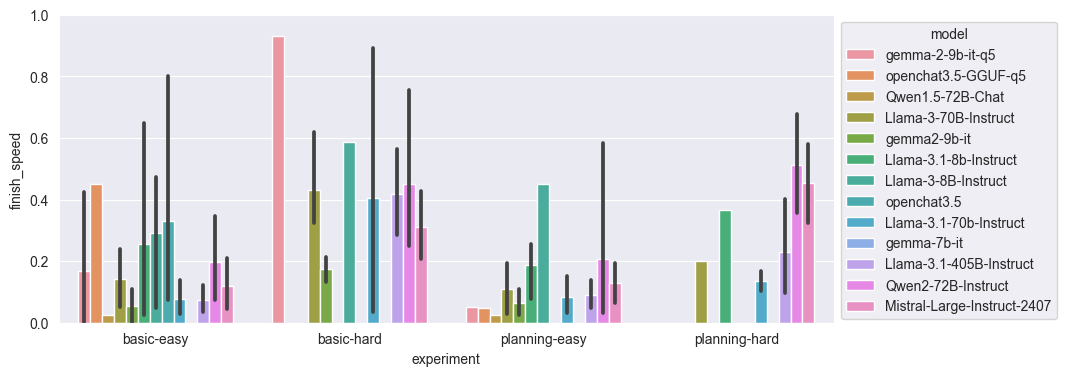

In [159]:
metric_bar_plot(game_df, "finish_speed")

Planning:

C:\Users\JJ\AppData\Local\Temp\ipykernel_15260\256060141.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = source_df[game_df.metric == metric].sort_values('experiment')


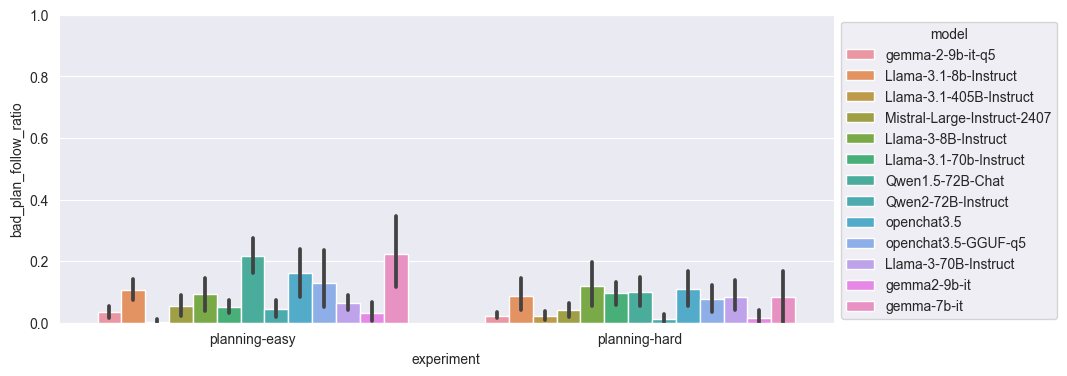

In [160]:
metric_bar_plot(plan_df, "bad_plan_follow_ratio")

C:\Users\JJ\AppData\Local\Temp\ipykernel_15260\256060141.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = source_df[game_df.metric == metric].sort_values('experiment')


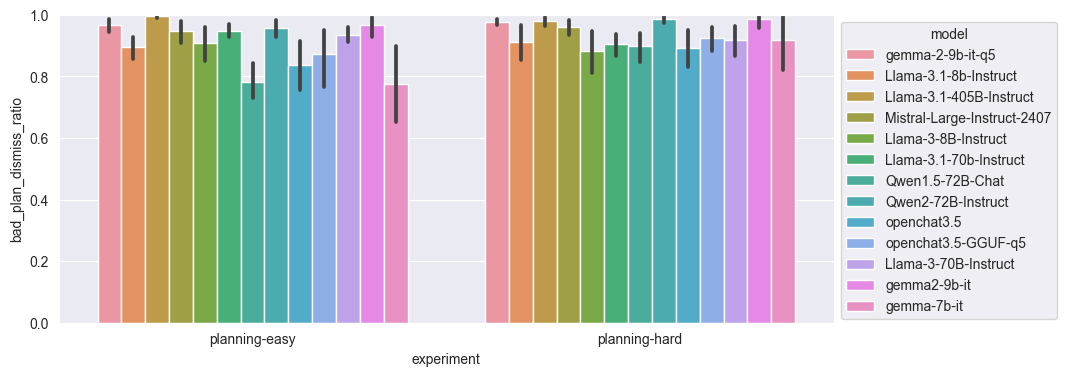

In [161]:
metric_bar_plot(plan_df, "bad_plan_dismiss_ratio")

C:\Users\JJ\AppData\Local\Temp\ipykernel_15260\256060141.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = source_df[game_df.metric == metric].sort_values('experiment')


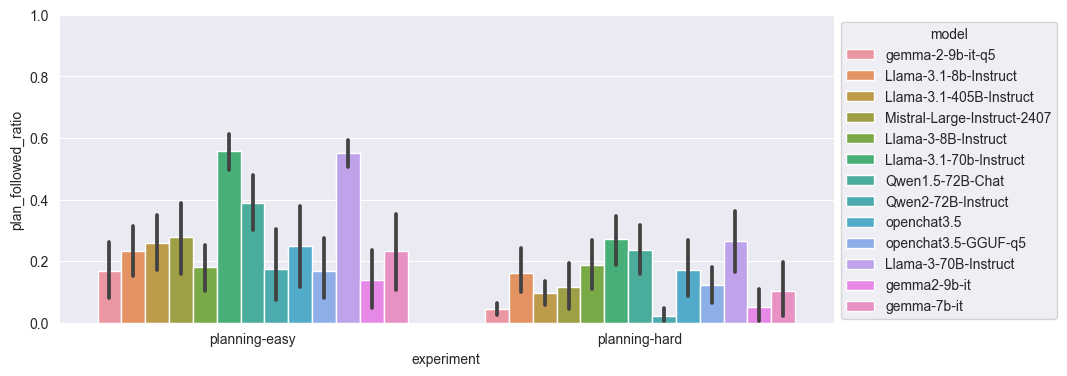

In [162]:
metric_bar_plot(plan_df, "plan_followed_ratio")

C:\Users\JJ\AppData\Local\Temp\ipykernel_15260\256060141.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = source_df[game_df.metric == metric].sort_values('experiment')


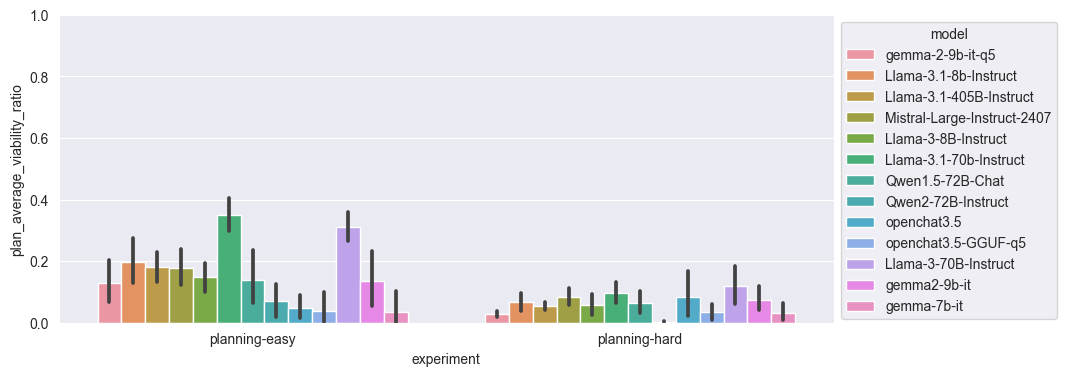

In [163]:
metric_bar_plot(plan_df, "plan_average_viability_ratio")